In [ ]:
#pkgs <- c("keras", "lime", "tidyquant", "rsample", "recipes", "yardstick", "corrr")
#install.packages(pkgs)

In [1]:
library(keras)
library(lime)
library(tidyquant)
library(rsample)
library(recipes)
library(yardstick)
library(corrr)

Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: PerformanceAnalytics
Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'PerformanceAnalytics'

The following object is masked from 'package:graphics':

    legend

Loading required package: quantmod
Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: tidyverse
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.0.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x lubridate::as.difftime() masks base::as.difftime()
x lubridate::date

In [2]:
df_train_x <- read.csv("../data/df_train_x.csv") %>% select(-X) %>% data.matrix
df_test_x <- read.csv("../data/df_test_x.csv") %>% select(-X) %>% data.matrix
vec_train_y <- read.csv("../data/vec_train_y.csv") %>% select(-X) %>% data.matrix
vec_test_y <- read.csv("../data/vec_test_y.csv") %>% select(-X) %>% data.matrix


In [ ]:
#install_keras()

In [3]:
model_keras <- keras_model_sequential()

model_keras %>% 
    # First hidden layer
    layer_dense(
        units              = 16, 
        kernel_initializer = "uniform", 
        activation         = "relu", 
        input_shape        = ncol(df_train_x)) %>% 
    # Dropout to prevent overfitting
    layer_dropout(rate = 0.1) %>%
    # Second hidden layer
    layer_dense(
        units              = 16, 
        kernel_initializer = "uniform", 
        activation         = "relu") %>% 
    # Dropout to prevent overfitting
    layer_dropout(rate = 0.1) %>%
    # Output layer
    layer_dense(
        units              = 1, 
        kernel_initializer = "uniform", 
        activation         = "sigmoid") %>% 
    # Compile ANN
    compile(
        optimizer = 'adam',
        loss      = 'binary_crossentropy',
        metrics   = c('accuracy')
    )
model_keras

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 16)                      672         
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 16)                      0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 16)                      272         
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 16)                      0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       17          
Total params: 961
Trainable params: 961
Non-trainable params: 0
_______________________________________

In [4]:
# Fit the keras model to the training data
base_model <- fit(
    object           = model_keras, 
    x                = df_train_x, 
    y                = vec_train_y,
    batch_size       = 40, 
    epochs           = 30,
    validation_split = 0.35
    )

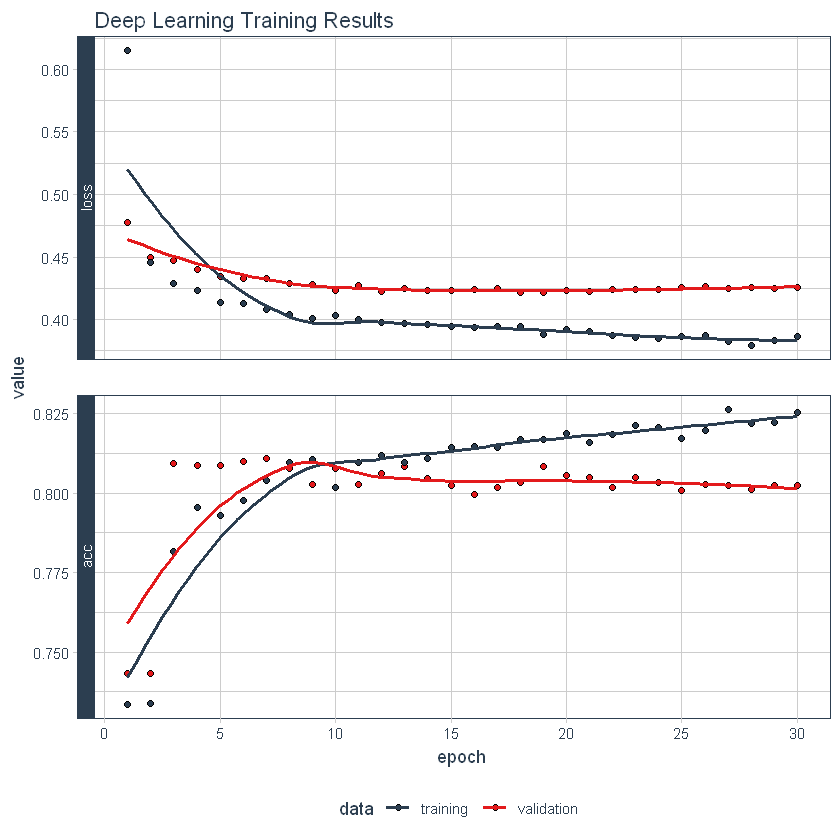

In [5]:
plot(base_model) +
    theme_tq() +
    scale_color_tq() +
    scale_fill_tq() +
    labs(title = "Deep Learning Training Results")

In [6]:
vec_pred_y <- predict_proba(object = model_keras, x = df_test_x)

In [7]:
# Predicted Class
yhat_keras_class_vec <- predict_classes(object = model_keras, x = df_test_x) %>%
    as.vector()

# Predicted Class Probability
yhat_keras_prob_vec  <- predict_proba(object = model_keras, x = df_test_x) %>%
    as.vector()

In [8]:
estimates_keras_tbl <- tibble(
    truth      = as.factor(vec_test_y) %>% fct_recode(yes = "1", no = "0"),
    estimate   = as.factor(yhat_keras_class_vec) %>% fct_recode(yes = "1", no = "0"),
    class_prob = yhat_keras_prob_vec
)

head(estimates_keras_tbl)

truth,estimate,class_prob
no,no,0.037652954
no,no,0.148298129
no,no,0.020644806
no,no,0.002335682
no,yes,0.798685193
no,no,0.003737462


In [9]:
estimates_keras_tbl %>% conf_mat(truth, estimate)

          Truth
Prediction   no  yes
       no  1146  231
       yes  128  253

In [10]:
# Accuracy
estimates_keras_tbl %>% metrics(truth, estimate)

accuracy
0.7957907


In [11]:
estimates_keras_tbl %>% roc_auc(truth, class_prob)

[1] 0.8341172

In [12]:
estimates_keras_tbl %>% f_meas(truth, estimate, beta=1)

[1] 0.8645794

In [13]:
# Precision
tibble(
    precision = estimates_keras_tbl %>% precision(truth, estimate),
    recall    = estimates_keras_tbl %>% recall(truth, estimate)
)

precision,recall
0.832244,0.899529


In [14]:
library(InformationValue)


Attaching package: 'InformationValue'

The following objects are masked from 'package:yardstick':

    npv, precision



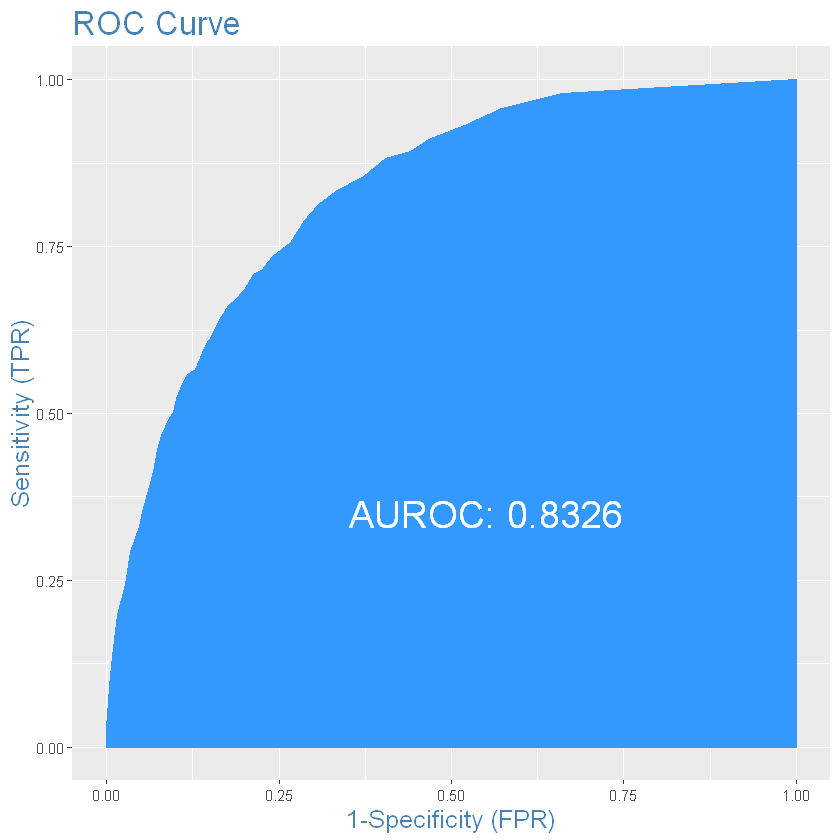

In [18]:
plotROC(actuals = as.numeric(vec_test_y), predictedScores = vec_pred_y)

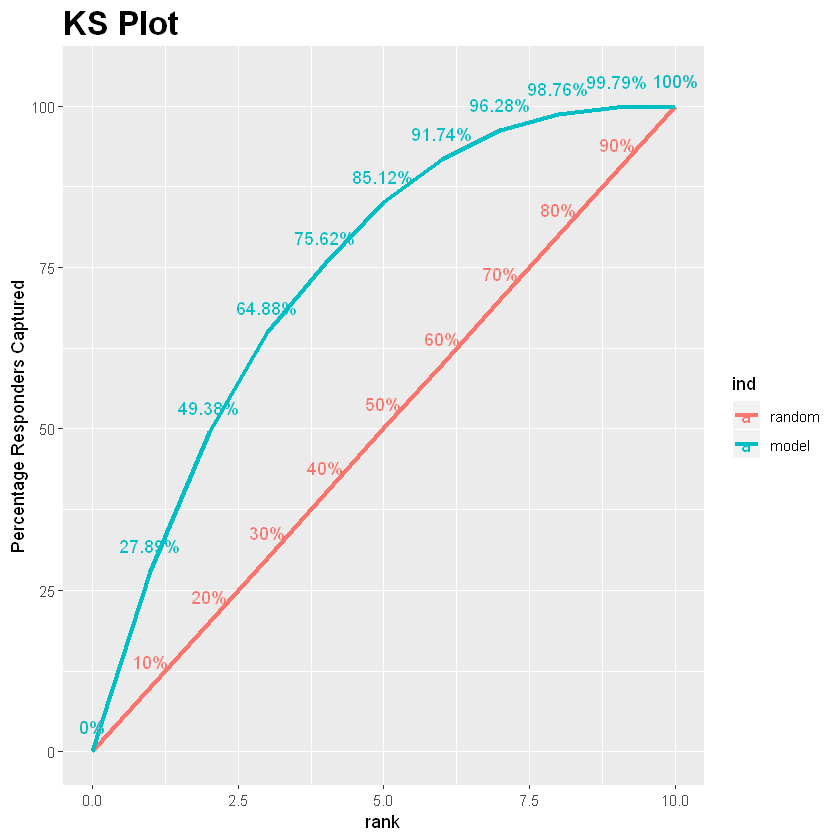

In [19]:
ks_plot(actuals = as.numeric(vec_test_y), predictedScores = vec_pred_y)